In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from rasterio.features import shapes
import geopandas as gpd

In [ ]:
import os
import shutil

# Define your source and target directories
source_directory = '/data5/SAM_test/SAS/SAMed-river/Embarras_2019/ROI/Embarrars_Stream_Order_Buffery'
target_directory = '/data5/SAM_test/SAS/SAMed-river/Embarras_2019/merge'

# Walk through the source directory
for dirpath, dirnames, filenames in os.walk(source_directory):
    # Construct the corresponding target directory path
    target_path = dirpath.replace(source_directory, target_directory)

    # Ensure the target directory exists
    os.makedirs(target_path, exist_ok=True)

    # Copy each file to the target directory
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        shutil.copy(file_path, target_path)

print("Files have been copied.")


In [2]:
tmp = 'SkySat2/20211211_204533_ssc14d1_0019_analytic_SR_clip.tif'

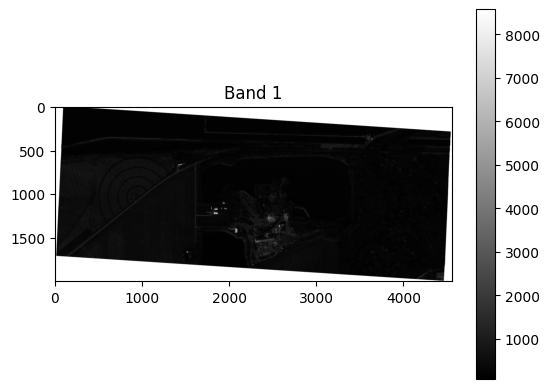

Statistics for Band 1:
Min: 79
Max: 8575
Mean: 1673.2362318331504
Std Dev: 3055.1150913344413



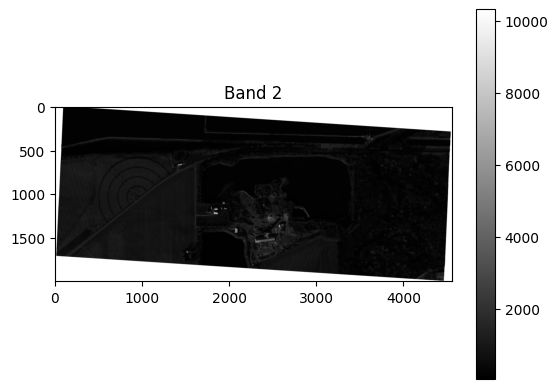

Statistics for Band 2:
Min: 63
Max: 10326
Mean: 2110.2771192096598
Std Dev: 3647.234132197345



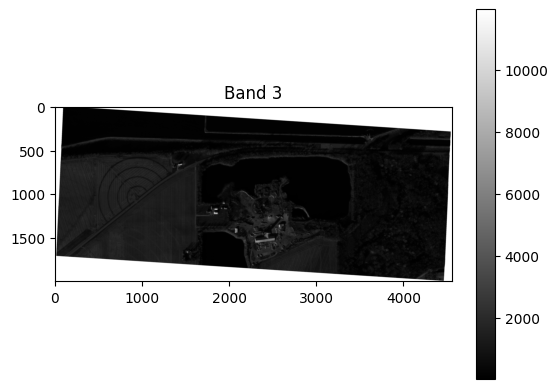

Statistics for Band 3:
Min: 39
Max: 11937
Mean: 2571.3595718990123
Std Dev: 4176.807182815603



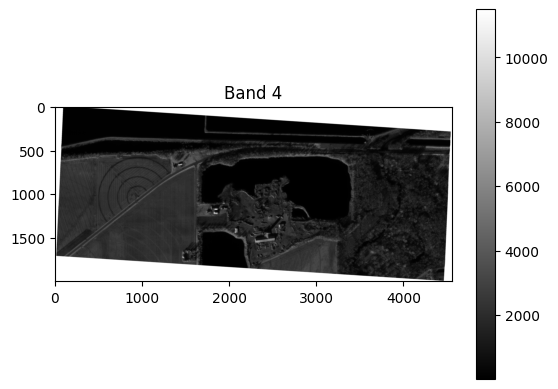

Statistics for Band 4:
Min: 22
Max: 11492
Mean: 2980.91425532382
Std Dev: 3874.453415169949



In [58]:
with rasterio.open(tmp) as src:
    # Read the entire stack of bands.
    bands = src.read()
    
    # Loop through each band.
    for i, band in enumerate(bands, start=1):
        # Display each band.
        band[band == np.min(band)] = np.max(band)
        plt.figure()
        plt.imshow(band, cmap='gray')
        plt.title(f'Band {i}')
        plt.colorbar()
        plt.show()
        
        # Optionally, print out statistics for each band.
        print(f'Statistics for Band {i}:')
        print(f'Min: {np.min(band)}')
        print(f'Max: {np.max(band)}')
        print(f'Mean: {np.mean(band)}')
        print(f'Std Dev: {np.std(band)}\n')

(2000, 4555, 3)
1.0 0.0


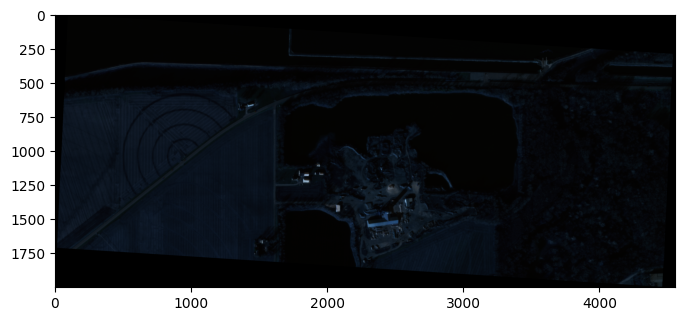

In [59]:
with rasterio.open(tmp) as src:
    img = src.read()[:3,:,:].transpose(1,2,0)
    print(img.shape)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    print(np.max(img), np.min(img))

/tmp/ipykernel_867412/596270266.py:5: RuntimeWarning: invalid value encountered in divide
  ndwi = (g - nir) / (g + nir)
/tmp/ipykernel_867412/596270266.py:6: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - r) / (nir + r)


nan nan


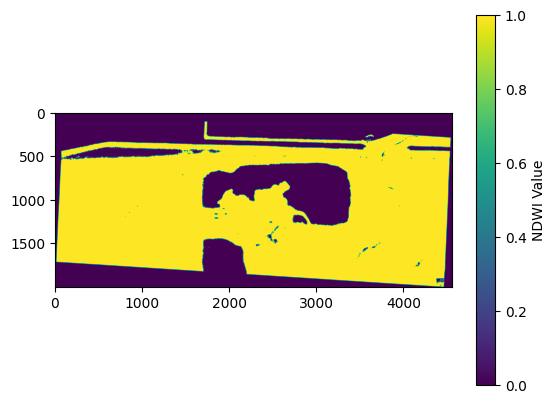

In [37]:
with rasterio.open(tmp) as src:
    r,g,b,nir = src.read()
    # ndwi = (g - nir) / (g + nir)
    # ndvi = (nir - r) / (nir + r)
    ndwi = (g / 255. - nir / 255.) / (g / 255. + nir / 255.)
    ndvi = (nir / 255. - r / 255.) / (nir / 255. + r / 255.)
    ndwi_modified = np.where(ndwi > 0.8, 1, 0)
    ndvi_modified = np.where(ndvi > 0.8, 1, 0)
    plt.imshow(ndwi_modified)
    plt.colorbar(label='NDWI Value')
    print(np.max(ndwi),np.min(ndwi))

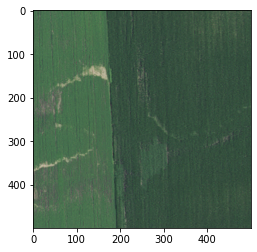

In [120]:
topleft = img[:500,:500,:]
plt.imshow(topleft)

In [41]:
# makeup mask

def makeup_mask(transform,tif_path,output_shp_path,h=512,w=512):
    binary_array = np.ones((h,w))
    mask = binary_array.astype(np.uint8)
    results = (
        {"properties": {"value": v}, "geometry": s}
        for _, (s, v) in enumerate(shapes(mask, transform=transform))
    )

    # Convert to a GeoDataFrame
    geoms = list(results)
    gdf = gpd.GeoDataFrame.from_features(geoms)

    # Filter out polygons that are from the background (value=0)
    gdf = gdf[gdf["value"] == 1]

    gdf.to_file(output_shp_path)

In [42]:
def NDWI(src):
    r,g,b,nir = src.read()
    ndwi = (g / 255. - nir / 255.) / (g / 255. + nir / 255.)
    ndvi = (nir / 255. - r / 255.) / (nir / 255. + r / 255.)
    return np.where(ndwi > 0.8, 1, 0)

def crop(src, i_c, j_c,crop_tif_path, s_path = None, h=512,w=512):
    transformer = rasterio.transform.AffineTransformer(src.transform)
    # top left geographics (x,y) coordinates of cropped tif
    x_offset, y_offset = transformer.xy(i_c, j_c)
    cropped_data = src.read()[:, i_c:i_c+h, j_c:j_c+w]
    original_tif = src.read()
#     print(f'original_tif has shape {original_tif.shape} but cut with i from {i_c} to {i_c+512} and j from {j_c} to {j_c+512}')
#     print(f'cropped_data has shape {cropped_data.shape}')
    
        # Adjust the transform
    transform = rasterio.Affine(src.transform.a, src.transform.b, x_offset,
                                src.transform.d, src.transform.e, y_offset)
    
    with rasterio.open(crop_tif_path, 'w', driver='GTiff',
                   height=cropped_data.shape[1],
                   width=cropped_data.shape[2],
                   count=src.count,
                   dtype=cropped_data.dtype,
                   crs=src.crs,
                   transform=transform) as dst:
                        dst.write(cropped_data)
    makeup_mask(transform,crop_tif_path, s_path,h,w)
    


def check_ndwi_sum(ndwi, img, i_c, j_c, h=512, w=512):
    """
    Check if the sum of NDWI values in a specific area is greater than 100.

    :param ndwi: NDWI array of shape (h, w)
    :param img: Image array of shape (4, h, w)
    :param i_c: Row index for the top-left corner of the cropped area
    :param j_c: Column index for the top-left corner of the cropped area
    :param h: Height of the cropped area
    :param w: Width of the cropped area
    :return: True if the sum of NDWI values in the area is greater than 100, False otherwise
    """
    if i_c + h > ndwi.shape[0] or j_c + w > ndwi.shape[1]:
        raise ValueError("Cropped area extends beyond the dimensions of the NDWI array")

    # Extract the corresponding area from the NDWI array
    ndwi_area = ndwi[i_c:i_c+h, j_c:j_c+w]

    # Check if the sum of the NDWI values in the area is greater than 100
    return np.sum(ndwi_area) > 100
    

def sliding_crop(src, ndwi, src_name, tif_dir, shp_dir, h=512, w=512):
    tif = src.read()
    _,tif_h,tif_w=tif.shape
    x_start,y_start=0,0
    x_end, y_end = 0,0
    while (y_end < tif_h):
        y_end = y_start + h
        if y_end > tif_h:
            y_start = tif_h - h
            if y_start < 0: break
            y_end = tif_h + 1
        x_start,x_end = 0,0
        while (x_end < tif_w):
            x_end = x_start + w
            if x_end > tif_w: 
                x_start = tif_w - w
                if x_start < 0: break
                x_end = tif_w + 1
            #if check_ndwi_sum(ndwi,img,y_start,x_start,h,w):
            if True:
                t_name = f'{src_name}_{y_start}_{x_start}.tif'
                t_path = os.path.join(tif_dir,t_name)
                s_name = f'{src_name}_{y_start}_{x_start}.shp'
                s_path = os.path.join(shp_dir,s_name)
                crop(src,y_start,x_start,t_path, s_path)
                
            x_start = x_end
        y_start = y_end

        
                

    

In [46]:
output_dir = 'SAMed_input/SkySat_image'
shp_dir = 'SAMed_input/SkySat_mask'
input_dir = 'SkySat/'
for filename in tqdm(os.listdir(input_dir)):
    with rasterio.open(input_dir+filename) as src:
        print(filename)
        #ndwi = NDWI(src)
        ndwi = None
        src_name = filename[:-4]
        sliding_crop(src,ndwi,src_name,output_dir,shp_dir)

  0%|          | 0/406 [00:00<?, ?it/s]

NAIP_73.tif


ValueError: not enough values to unpack (expected 4, got 3)